# *FORECASTING* CON REDES LSTM - MODELO MULTIVARIADO - UNISTEP Y MULTISTEP

## Contenido

1. [Introducción](#introduccion)
2. [El set de datos](#setdatos)
3. [El problema a resolver](#problema)
4. [Lectura del set de datos](#lectura)
5. [Procesamiento inicial del dataset](#)
6. [Análisis exploratorio](#)
7. [Pre-procesamiento](#)
8. [Conclusión](#)

## 1. Introducción <a id='introduccion'></a>

Primero se deben recopilar y preparar los datos. El siguiente paso sería entrenar el modelo utilizando técnicas de aprendizaje profundo y optimización para mejorar la precisión de las predicciones. Este modelo se puede utilizar para predecir valores futuros en una sola etapa (unistep), o para hacer predicciones en múltiples etapas futuras (multistep).

La implementación de un modelo LSTM multivariado unistep y multistep puede proporcionar una herramienta poderosa para la toma de decisiones basadas en datos precisos y procesables en una variedad de contextos comerciales y de investigación.

La idea es predecir el tiempo de viaje una hora a futuro (de ahí el término unistep) o bien de dos a mas horas (multistep) usando como entrada al modelo los registros historicos tales como el dia de la semana, paradero inicial, paradero destino, el tiempo de viaje (de ahí el término multivariado).

## 2. El set de datos <a id='setdatos'></a>

Se usa el dataset de los registros de GPS de la empresa Leon de San Jeronimo, un set de datos que contiene el registro histórico de 14 diferentes variables en el período de marzo 2023.

Se realizó e análisis exploratorio del dataset y su pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos (outliers)
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora

## 3. El problema a resolver <a id='problema'></a>

Crear y entrenar una Red LSTM usando el enfoque univariado + single-step:

## 4. Lectura del set de datos <a id='lectura'></a>

In [1]:
import keras
import matplotlib
import subprocess
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.python.platform import build_info as build
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM, Dense,BatchNormalization, Dropout, RepeatVector, TimeDistributed, ConvLSTM2D, Flatten, Reshape
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
#from tensorflow.keras.layers import CuDNNLSTM, Dense

In [2]:
print("Tensorflow".ljust(25) + f":{tf.__version__}")
print("Keras".ljust(25) + f":{keras.__version__}")
print("GPU Available".ljust(25) + f":{len(tf.config.experimental.list_physical_devices('GPU'))}")
print("Cuda Built".ljust(25) + f":{tf.test.is_built_with_cuda()}")
print("Cuda Version".ljust(25) + f":{build.build_info['cuda_version'].split('_')[1][:2]}" +"."+ f"{build.build_info['cuda_version'].split('_')[1][2:]}")
print("Cudnn Version".ljust(25) + f":{build.build_info['cudnn_version'].split('_')[1]}")
print("List Tensorflow GPUs".ljust(25) + f":{tf.config.list_physical_devices('GPU')}")
print("Name of GPU".ljust(25) + f":{subprocess.check_output('nvidia-smi --query-gpu=gpu_name --format=csv', shell=True).decode().splitlines()[1]}")
print("Numpy Version".ljust(25) + f":{np.__version__}")
print("Pandas Version".ljust(25) + f":{pd.__version__}")
print("Matplotlib Version".ljust(25) + f":{matplotlib.__version__}")
print("Seaborn Version".ljust(25) + f":{sns.__version__}")

Tensorflow               :2.10.1
Keras                    :2.10.0
GPU Available            :1
Cuda Built               :True
Cuda Version             :11.2
Cudnn Version            :8
List Tensorflow GPUs     :[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name of GPU              :NVIDIA GeForce RTX 3070 Ti Laptop GPU
Numpy Version            :1.24.3
Pandas Version           :1.5.3
Matplotlib Version       :3.7.1
Seaborn Version          :0.12.2


Se selecciona ciertas columnas que se consideran relevantes para preparar las secuencias posteriormente

- "id_sample": es un identificador único para cada muestra en la tabla.
- "init_stop": representa la parada inicial en la ruta.
- "end_stop": representa la parada final en la ruta.
- "linkref": es un identificador único para cada enlace de referencia en la ruta.
- "date_time_init": es la fecha y hora en que se inició el recorrido en la ruta.
- "date_time_end": es la fecha y hora en que se finalizó el recorrido en la ruta.
- "time_travel": representa la duración del viaje entre la parada inicial y la parada final.

In [ ]:
data = pd.read_csv('../data/samples_without_nan.csv', usecols=['id_sample','init_stop', 'end_stop', 'linkref', 'date_time_init', 'date_time_end', 'time_travel'])
data['date_time_init'] = pd.to_datetime(data['date_time_init'])
data['date_time_end'] = pd.to_datetime(data['date_time_end'])
data['DayOfWeek'] = data['date_time_init'].dt.weekday
#data.set_index('date_time_init', inplace= True)
data

Imprimir si existen NAN en el dataset

In [ ]:
print('Cantidad de NaNs:')
for column in data:
    nans = data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Mostrar los 15 datos con viaje de paradero a paradero mas duraderos

In [ ]:
max_x=data.nlargest(15, ['time_travel'])
max_x

Mostrar los 15 datos con viaje de paradero a paradero menos duraderos

In [ ]:
min_x=data.nsmallest(15, ['time_travel'])
min_x

Observacion de los datos del time_travel

In [ ]:
plt.figure(figsize=(15, 6))
data['time_travel'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Time Travel")
plt.tight_layout()
plt.show()

Observacion de las columnas del dataset

In [ ]:
cols = data.columns

# Dibujar la totalidad de registros
N = data.shape[0]       # Número de registros
plots = data[cols][0:N] # Series de tiempo individuales
plots.index = data.index[0:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(12,16))


Ajuste de periodicidad, en estas pruebas se considera hacer fracciones de tiempo cada 1 minuto

In [ ]:
#Crear una columna que sera indice de periodicidad
ix = pd.DatetimeIndex(pd.to_datetime(data['date_time_init'])).floor('1min')#.floor('10S')#.floor('0.1min')
data["datetime"] = ix

#Crear indice datetime
data.set_index('datetime', inplace= True)
data

Elegir un sample y mostrar las diferencias de tiempo para observar los tiempos repetidos que son representados por los 0

In [ ]:
#Se filtra un sample y se ejecuta el analisis
df_filtrado = data[data['id_sample'] == 0]
df_time_diffs = df_filtrado.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

Elegir todos samples y mostrar las diferencias de tiempo para observar los tiempos repetidos que son representados por los 0

In [ ]:
df_list = pd.DataFrame()
#Iterar los samples y concatenar
for value in data['id_sample'].unique():
    df_filtrado = data[data['id_sample'] == value]
    df_time_diffs = df_filtrado.index.to_series().diff().dt.total_seconds()
    df_list = pd.concat([df_list,df_time_diffs], axis=0)

print(df_list.value_counts())

Guardar dataset procesado

In [ ]:
data.to_csv('../data/dataset_v1.csv')

# Crear sets de entrenamiento, validación y prueba

In [3]:
def change_column(dataframe, column, index_column):
    column_tmp = dataframe.pop(column)
    dataframe.insert(index_column, column, column_tmp)
    return dataframe

Leer el dataset procesado anteriormente

In [4]:
df = pd.read_csv('../data/travel_time_series_2col.csv', usecols=['linkref', 'travel_time','horas','minute'])

# Cambiar de posicion las columnas de horas y minutos
df = change_column(df, column = 'horas',index_column = 1)
df = change_column(df, column = 'minute',index_column = 2)

# Crea un diccionario para mapear los valores únicos a la codificación numérica
diccionario_codificacion = {valor: indice for indice, valor in enumerate(df['linkref'].unique())}

# Aplica la codificación a la columna
df['links'] = df['linkref'].map(diccionario_codificacion)

# Cambiar de posicion la columna links
df = change_column(df, column = 'links',index_column = 0)

# Imprime los valores originales y los codificados
print("Valores originales:  ", df['linkref'].values)
print("Valores codificados: ", df['links'].values)

# Eliminar la columna linkref
df = pd.DataFrame(df.drop('linkref', axis=1))

#Mostrar dataframe
df.head(5)

Valores originales:   ['0:36' '36:37' '37:38' ... '115:116' '116:117' '117:118']
Valores codificados:  [ 0  1  2 ... 80 81 82]


,links,horas,minute,travel_time
0,0,7,30,191.0
1,1,7,30,106.0
2,2,7,30,90.0
3,3,7,30,24.0
4,4,7,30,76.0


In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#scaler_time_travel = MinMaxScaler()
#scaler_links = MinMaxScaler()

#df['time_travel'] = df['time_travel'].astype(float)  # Convertir a punto flotante
#df['time_travel'] = scaler_time_travel.fit_transform(df['time_travel'].values.reshape(-1, 1))

#df['links'] = df['links'].astype(float)  # Convertir a punto flotante
#df['links'] = scaler_links.fit_transform(df['links'].values.reshape(-1, 1))

#df

In [ ]:
# Realizar la transformación inversa de 'time_travel'
#df['time_travel2'] = scaler_time_travel.inverse_transform(df['time_travel'].values.reshape(-1, 1))

# Realizar la transformación inversa de 'links'
#df['links2'] = scaler_links.inverse_transform(df['links'].values.reshape(-1, 1))

# Verificar el resultado
#print(df)

Separar datos 

In [5]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

separar datos samples

In [6]:
def train_val_test_split_samples(dataset, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # dividir el dataset por nro de samples
    n_sample = dataset.shape[0] / 83

    # Definir número de datos en cada subserie
    N = dataset.shape[0]
    Ntrain = int(n_sample * tr_size) * 83 # Número de datos de entrenamiento
    Nval = int(n_sample * vl_size) * 83   # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataset[0:Ntrain]
    val = dataset[Ntrain:Ntrain+Nval]
    test = dataset[Ntrain+Nval:]

    return train, val, test

Se dispondra que del total de samples:
  - 80% seran para entrenamiento
  - 10% para validación 
  - 10% para test

In [7]:
tr_size=0.8
vl_size=0.1 
ts_size=0.1

#tr, vl, ts = train_val_test_split(df)

#tr_size=170067 #80% aproximadamente
#vl_size=21165  #10% aproximadamente
#ts_size=21165  #10% aproximadamente

tr, vl, ts = train_val_test_split_samples(df)

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño total de datos      ({100}%):  {df.shape[0]}')
print(f'Tamaño set de entrenamiento ({int(tr_size*100)}%):  {tr.shape} ({int(tr.shape[0]/83)} samples)')
print(f'Tamaño set de validación    ({int(vl_size*100)}%):  {vl.shape} ({int(vl.shape[0]/83)} samples)')
print(f'Tamaño set de prueba        ({int(ts_size*100)}%):  {ts.shape} ({int(ts.shape[0]/83)} samples)')

Tamaño total de datos      (100%):  212397
Tamaño set de entrenamiento (80%):  (169901, 4) (2047 samples)
Tamaño set de validación    (10%):  (21165, 4) (255 samples)
Tamaño set de prueba        (10%):  (21331, 4) (257 samples)


Mostrar los datos que se han dividido

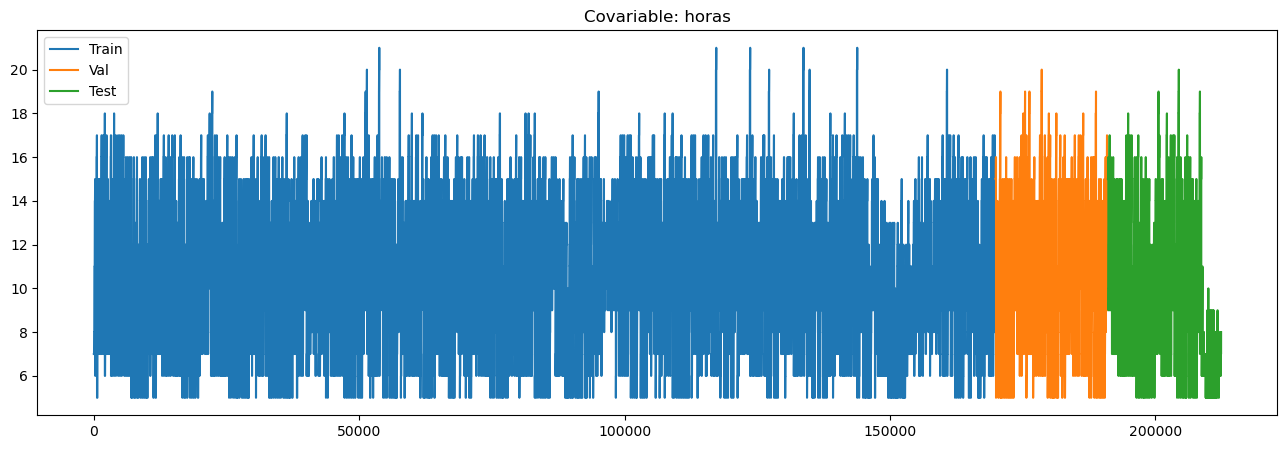

In [8]:
covar = 1 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

Generar los datasets normalizados y organizar secuencias

In [8]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos, f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [9]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 83    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (169817, 83, 4), y_tr: (169817, 1, 1)
Set de validación - x_vl: (21081, 83, 4), y_vl: (21081, 1, 1)
Set de prueba - x_ts: (21247, 83, 4), y_ts: (21247, 1, 1)


In [10]:
def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    #scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]
    #scalers = [StandardScaler() for i in range(NFEATS)]
    scalers = [RobustScaler() for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        
        #Escalar todo
        # x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        # x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        # x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

        #Escalar solo la variable de tiempo
        if i== NFEATS-1:
            x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
            x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
            x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
        else:
            x_tr_s[:,:,i] = x_tr[:,:,i]
            x_vl_s[:,:,i] = x_vl[:,:,i]
            x_ts_s[:,:,i] = x_ts[:,:,i]

    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [11]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in, col_ref = 'travel_time')

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
# print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr[:,:,3].min()}/{x_vl[:,:,3].min()}/{x_ts[:,:,3].min()}')
# print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s[:,:,3].min()}/{x_vl_s[:,:,3].min()}/{x_ts_s[:,:,3].min()}')

# print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
# print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

# print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr[:,:,3].max()}/{x_vl[:,:,3].max()}/{x_ts[:,:,3].max()}')
# print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s[:,:,3].max()}/{x_vl_s[:,:,3].max()}/{x_ts_s[:,:,3].max()}')

# print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
# print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

In [12]:
# Crear un diccionario con los datos
data_scal = {
    'Mínimo sin escalamiento': [x_tr[:,:,3].min(), x_vl[:,:,3].min(), x_ts[:,:,3].min(), y_tr.min(), y_vl.min(), y_ts.min()],
    'Mínimo con escalamiento': [x_tr_s[:,:,3].min(), x_vl_s[:,:,3].min(), x_ts_s[:,:,3].min(), y_tr_s.min(), y_vl_s.min(), y_ts_s.min()],
    'Máximo sin escalamiento': [x_tr[:,:,3].max(), x_vl[:,:,3].max(), x_ts[:,:,3].max(), y_tr.max(), y_vl.max(), y_ts.max()],
    'Máximo con escalamiento': [x_tr_s[:,:,3].max(), x_vl_s[:,:,3].max(), x_ts_s[:,:,3].max(), y_tr_s.max(), y_vl_s.max(), y_ts_s.max()]
}

# Crear el DataFrame
pd.DataFrame(data_scal, index=['x_tr', 'x_vl', 'x_ts', 'y_tr', 'y_vl', 'y_ts'])

,Mínimo sin escalamiento,Mínimo con escalamiento,Máximo sin escalamiento,Máximo con escalamiento
x_tr,4.0,-0.851064,1991.0,41.425532
x_vl,4.0,-0.851064,1492.0,30.808511
x_ts,3.0,-0.872340,985.0,20.021277
y_tr,4.0,-0.851064,1991.0,41.425532
y_vl,4.0,-0.851064,1492.0,30.808511
y_ts,3.0,-0.872340,985.0,20.021277


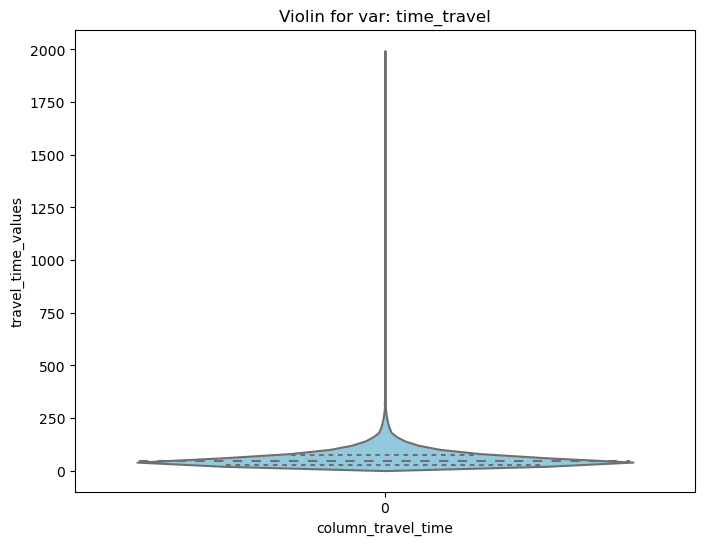

In [14]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=x_tr[:,:,3].flatten(), color='skyblue', inner='quartile')
plt.xlabel('column_travel_time')
plt.ylabel('travel_time_values')
plt.title('Violin for var: time_travel')

# Mostrar el gráfico
plt.show()

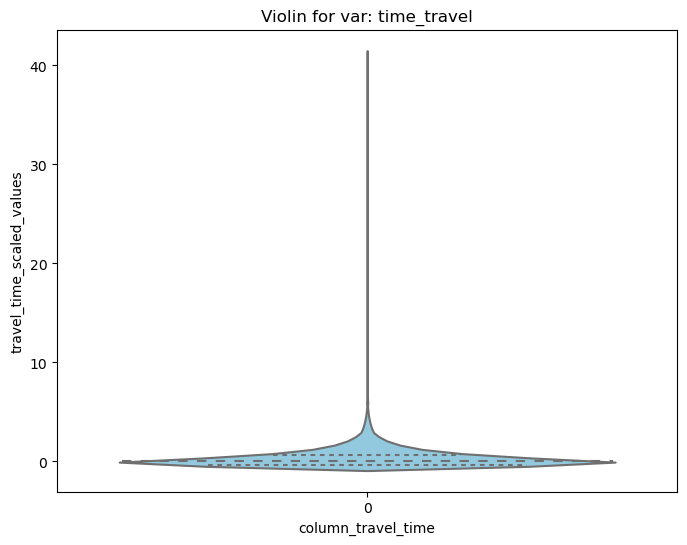

In [15]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=x_tr_s[:,:,3].flatten(), color='skyblue', inner='quartile')
plt.xlabel('column_travel_time')
plt.ylabel('travel_time_scaled_values')
plt.title('Violin for var: time_travel')

# Mostrar el gráfico
plt.show()

In [ ]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(4,4))
for i in range(2):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(2)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

In [ ]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(4, 8))

# Datos de violín
data = [y_tr_s.flatten(), y_vl_s.flatten(), y_ts_s.flatten()]

# Colores para los violines
colors = ['blue', 'orange', 'green']

# Posiciones de los violines
positions = [1, 2, 3]

# Crear los gráficos de violín
violins=ax.violinplot(dataset=data, positions=positions, showmeans=False, showmedians=True)

# Ajustar etiquetas y colores
ax.set_xticks(positions)
ax.set_xticklabels(['Train', 'Validation', 'Test'])
for patch, color in zip(violins['bodies'], colors):
    patch.set_facecolor(color)

# Ajustar el título y los ejes
ax.set_title('Comparación de datos de violín')
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Valores')

# Mostrar el gráfico
plt.show()

In [ ]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(2,8))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida): travel_time']);

In [ ]:
def LSTM_Model(INPUT_SHAPE):
    modelo = Sequential()
    modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE), return_sequences=True)
    modelo.add(LSTM(N_UNITS))

In [13]:
x_tr_s= x_tr_s.reshape(x_tr_s.shape[0], x_tr_s.shape[1], x_tr_s.shape[2], 1, 1)
x_vl_s= x_vl_s.reshape(x_vl_s.shape[0], x_vl_s.shape[1], x_vl_s.shape[2], 1, 1)
x_ts_s= x_ts_s.reshape(x_ts_s.shape[0], x_ts_s.shape[1], x_ts_s.shape[2], 1, 1)

y_tr_s = y_tr_s.reshape(y_tr_s.shape[0], y_tr_s.shape[1], y_tr_s.shape[2], 1, 1)
y_vl_s = y_vl_s.reshape(y_vl_s.shape[0], y_vl_s.shape[1], y_vl_s.shape[2], 1, 1)
y_ts_s = y_ts_s.reshape(y_ts_s.shape[0], y_ts_s.shape[1], y_ts_s.shape[2], 1, 1) 

In [14]:
x_tr_s.shape, x_vl_s.shape ,x_ts_s.shape

((169817, 83, 4, 1, 1), (21081, 83, 4, 1, 1), (21247, 83, 4, 1, 1))

In [23]:
pip install --upgrade nvidia-tensorrt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\etson\AppData\Local\Temp\pip-install-ypwfnhqc\nvidia-tensorrt_1d0af6f3bf7c4ba597b7cef70fdd3ff8\setup.py", line 150, in <module>
          raise RuntimeError(open("ERROR.txt", "r").read())
      RuntimeError:
      ###########################################################################################
      The package you are trying to install is only a placeholder project on PyPI.org repository.
      This package is hosted on NVIDIA Python Package Index.
      
      This package can be installed as:
      ```
      $ pip install nvidia-pyindex
      $ pip install nvidia-tensorrt
      ```
      #################################################################################

In [251]:
# Creación del modelo

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2], 1, 1) # 24 (horas) x 13 (features)
#print(INPUT_SHAPE)
#MODELO 1
# modelo = Sequential()
# modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE, return_sequences = False))
# # Y lo único que cambia con respecto al modelo multivariado + uni-step es el tamaño del dato de salida
# modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
#FIN MODELO 1

#MODELO 2
# modelo = Sequential()
# modelo.add(BatchNormalization(name = 'batch_norm_0', input_shape = INPUT_SHAPE))
# modelo.add(LSTM(name ='lstm_1', units = 128, return_sequences = True))
# modelo.add(Dropout(0.15, name = 'dropout_1'))
# modelo.add(BatchNormalization(name = 'batch_norm_1'))
# modelo.add(LSTM(name ='lstm_2', units = 128, return_sequences = False))
# modelo.add(Dropout(0.1, name = 'dropout_2'))
# modelo.add(BatchNormalization(name = 'batch_norm_2'))
# modelo.add(RepeatVector(1))
# modelo.add(LSTM(name ='lstm_3', units = 128, return_sequences = True))
# modelo.add(Dropout(0.15, name = 'dropout_3'))
# modelo.add(BatchNormalization(name = 'batch_norm_3'))
# modelo.add(LSTM(name ='lstm_4', units = 128, return_sequences = False))
# modelo.add(Dense(units = OUTPUT_LENGTH, name = 'dense_1', activation = 'linear'))
#FIN MODELO 2

# MODELO 3
# modelo = Sequential()
# modelo.add(BatchNormalization(name = 'batch_norm_0', input_shape = (83,4,1,1)))
# modelo.add(ConvLSTM2D(name ='lstm_1', filters=16, kernel_size=(10, 1), padding = 'same', return_sequences = False))
# #modelo.add(Flatten())
# modelo.add(Dense(units = OUTPUT_LENGTH, name = 'dense_1', activation = 'linear'))

# MODELO 4

modelo = Sequential()
modelo.add(BatchNormalization(name = 'batch_norm_0', input_shape = (83,4,1,1)))
modelo.add(ConvLSTM2D(name ='lstm_1', filters=128, kernel_size=(4, 1), padding = 'same', return_sequences = True))
modelo.add(Dropout(0.10, name = 'dropout_1'))
modelo.add(BatchNormalization(name = 'batch_norm_1'))

modelo.add(ConvLSTM2D(name ='conv_lstm_2', filters = 128, kernel_size = (4, 1), padding='same', return_sequences = False))
modelo.add(Dropout(0.10, name = 'dropout_2'))
modelo.add(BatchNormalization(name = 'batch_norm_2'))
modelo.add(Flatten())
modelo.add(RepeatVector(1))
modelo.add(Reshape((1, 4, 1, 128)))

modelo.add(ConvLSTM2D(name ='conv_lstm_3', filters = 128, kernel_size = (4, 1), padding='same', return_sequences = True))
modelo.add(Dropout(0.10, name = 'dropout_3'))
modelo.add(BatchNormalization(name = 'batch_norm_3')) 

modelo.add(ConvLSTM2D(name ='conv_lstm_4', filters = 128, kernel_size = (4, 1), padding='same', return_sequences = False))
modelo.add(Dense(units = OUTPUT_LENGTH, name = 'dense_1', activation = 'linear'))
modelo.add(Reshape(target_shape=(1, 1, 1)))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=6e-5) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
    metrics=['mse', 'mae']
)

ValueError: Exception encountered when calling layer "reshape_55" (type Reshape).

total size of new array must be unchanged, input_shape = [4, 1, 1], output_shape = [1, 1, 1]

Call arguments received by layer "reshape_55" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 4, 1, 1), dtype=float32)

In [246]:
modelo.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormaliz  (None, 83, 4, 1, 1)      4         
 ation)                                                          
                                                                 
 lstm_1 (ConvLSTM2D)         (None, 83, 4, 1, 128)     264704    
                                                                 
 dropout_1 (Dropout)         (None, 83, 4, 1, 128)     0         
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 83, 4, 1, 128)    512       
 ation)                                                          
                                                                 
 conv_lstm_2 (ConvLSTM2D)    (None, 4, 1, 128)         524800    
                                                                 
 dropout_2 (Dropout)         (None, 4, 1, 128)       

In [ ]:
# Entrenamiento (aproximadamente 8 min usando GPU)
EPOCHS = 30 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s)
)

In [ ]:
# Entrenamiento (aproximadamente 8 min usando GPU)
EPOCHS = 30 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s)
)

In [21]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(historia.history) 

# save to json:  
hist_json_file = 'HISTORY_ConvLSTM_ENCODER_DECODER_Robus_epo30_batch256.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'HISTORY_ConvLSTM_ENCODER_DECODER_Robus_epo30_batch256.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [16]:
modelo.save('ConvLSTM_ENCODER_DECODER_Robus_epo30_batch256.h5')

In [21]:
modelo.save('ConvLSTM_Robus_epo30_batch1024.h5')

In [16]:
modelo.save('ConvLSTM_Robus_epo100_batch256.h5')

In [25]:
modelo.save('Robus_Scaler_4-LSTM-unistep_4cov_MSE_MAE_100.h5')

In [ ]:
modelo.save('Standard_Scaler_4LSTM-1min_4cov_MSE_MAE_200.h5')

In [ ]:
modelo.save('Standard_Scaler_4LSTM-1min_4cov_MSE_MAE.h5')

In [ ]:
modelo.save('Standard_Scaler_LSTM-1min_4cov.h5')

In [189]:
from keras.models import load_model

# cargar modelo
#modelo = load_model('LSTM-1min_.h5')
optimizador = RMSprop(learning_rate=6e-5)
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse
modelo = load_model('ConvLSTM_Robus_epo100_batch256.h5', compile=False)
modelo.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mse', 'mae'])

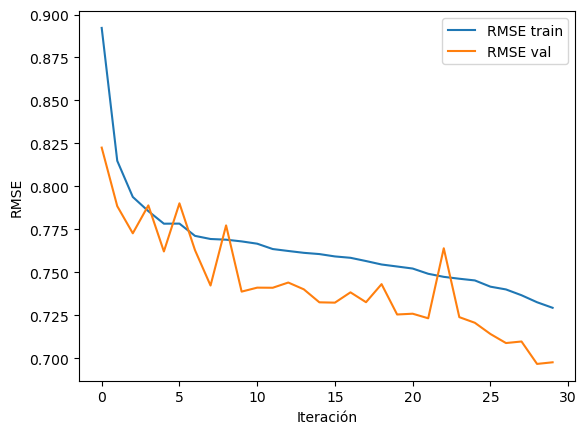

In [17]:
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

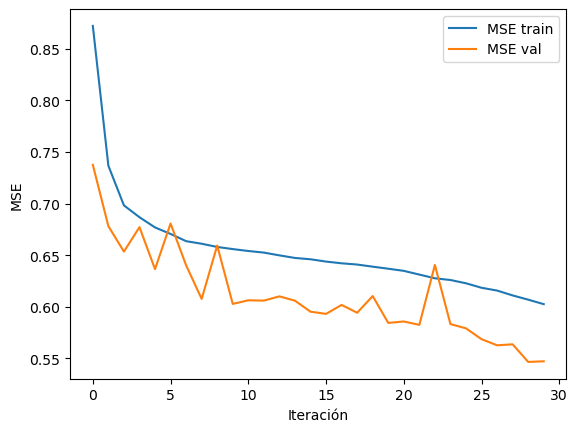

In [18]:
plt.plot(historia.history['mse'],label='MSE train')
plt.plot(historia.history['val_mse'],label='MSE val')
plt.xlabel('Iteración')
plt.ylabel('MSE')
plt.legend();

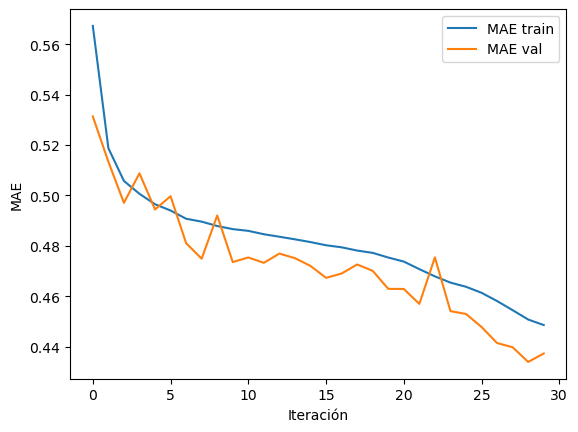

In [19]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['mae'],label='MAE train')
plt.plot(historia.history['val_mae'],label='MAE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

In [22]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=1)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=1)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=1)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr[0]:.3f}')
print(f'  RMSE val:\t {rmse_vl[0]:.3f}')
print(f'  RMSE test:\t {rmse_ts[0]:.3f}\n')

print(f'  MSE train:\t {rmse_tr[1]:.3f}')
print(f'  MSE val:\t {rmse_vl[1]:.3f}')
print(f'  MSE test:\t {rmse_ts[1]:.3f}\n')

print(f'  MAE train:\t {rmse_tr[2]:.3f}')
print(f'  MAE val:\t {rmse_vl[2]:.3f}')
print(f'  MAE test:\t {rmse_ts[2]:.3f}')

664/664 [==============================] - 105s 158ms/step - loss: 0.6102 - mse: 0.4436 - mae: 0.4300
Comparativo desempeños:
  RMSE train:	 0.646
  RMSE val:	 0.636
  RMSE test:	 0.610

  MSE train:	 0.583
  MSE val:	 0.547
  MSE test:	 0.444

  MAE train:	 0.440
  MAE val:	 0.437
  MAE test:	 0.430


In [ ]:
# Imprimir resultados en pantalla
print('Comparativo desempeños escalado:')
print(f'  RMSE train:\t {scaler.inverse_transform([[rmse_tr[0]]])[0][0]/60:.3f} min')
print(f'  RMSE val:\t {scaler.inverse_transform([[rmse_vl[0]]])[0][0]/60:.3f} min')
print(f'  RMSE test:\t {scaler.inverse_transform([[rmse_ts[0]]])[0][0]/60:.3f} min\n')

print(f'  MSE train:\t {scaler.inverse_transform([[rmse_tr[1]]])[0][0]/60:.3f} min')
print(f'  MSE val:\t {scaler.inverse_transform([[rmse_vl[1]]])[0][0]/60:.3f} min')
print(f'  MSE test:\t {scaler.inverse_transform([[rmse_ts[1]]])[0][0]/60:.3f} min\n')

print(f'  MAE train:\t {scaler.inverse_transform([[rmse_tr[2]]])[0][0]/60:.3f} min')
print(f'  MAE val:\t {scaler.inverse_transform([[rmse_vl[2]]])[0][0]/60:.3f} min')
print(f'  MAE test:\t {scaler.inverse_transform([[rmse_ts[2]]])[0][0]/60:.3f} min')

In [22]:
vector_reshape = x_tr_s.reshape(-1, 4)
# Crear el DataFrame con 4 columnas
df_vector_reshape = pd.DataFrame(vector_reshape, columns=['Links', 'Hora', 'Minuto', 'TiempoViaje'])
df_vector_reshape[0:83]

,Links,Hora,Minuto,TiempoViaje
0,0.0,7.0,30.0,2.707209
1,1.0,7.0,30.0,0.993846
2,2.0,7.0,30.0,0.671294
3,3.0,7.0,30.0,-0.659116
4,4.0,7.0,30.0,0.389058
...,...,...,...,...
78,78.0,8.0,45.0,-0.900975
79,79.0,8.0,45.0,-0.074582
80,80.0,8.0,45.0,-0.699415
81,81.0,8.0,45.0,-0.860662


In [52]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=1)
    y_pred_s = y_pred_s[:, 0, 0, 0].reshape((-1, 1))
    #y_pred_s = np.squeeze(y_pred_s)


    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [31]:
# PRUEBAS con salida (None, 4, 1 , 1) ==> (None, 1, 1, 1)
predicciones = modelo.predict(x_ts_s,verbose=1)
y_pred_s_columm = predicciones[:, 0, 0, 0]
y_pred_s = scaler.inverse_transform(y_pred_s_columm.reshape((-1, 1)))
y_ts_pred = y_pred_s.flatten()

664/664 [==============================] - 121s 182ms/step


In [194]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

664/664 [==============================] - 45s 67ms/step


In [51]:
print('Shape de la prediccion: ', y_ts_pred.shape)
print('Shape de la etiqueta: ', y_ts.shape)

Shape de la prediccion:  (21247,)
Shape de la etiqueta:  (21247, 1, 1)


In [196]:
# Calcular predicciones sobre el set de entrenamiento
y_train_predictions = predecir(x_tr_s, modelo, scaler)

5307/5307 [==============================] - 478s 90ms/step


### Calcular el error simple 

error promedio:  -0.16819559925779734


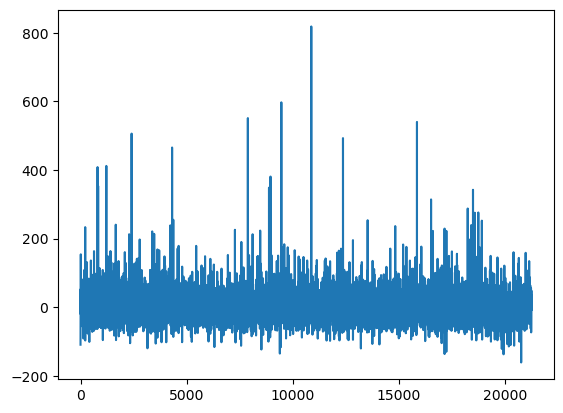

In [197]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
error = y_ts.flatten()-y_ts_pred
plt.plot(error);
print('error promedio: ', np.mean(error))

Incertidumbre de valores predecidos en general

In [41]:
# Calcula los residuos
residuos = error

# Define el nivel de confianza deseado (por ejemplo, 95%)
nivel_confianza = 95

# Calcula el percentil inferior y superior del intervalo
percentil_inferior = (100 - nivel_confianza) / 2
percentil_superior = 100 - percentil_inferior

# Calcula el intervalo simétrico utilizando los percentiles
intervalo_simetrico = np.percentile(residuos, [percentil_inferior, percentil_superior])

print("Intervalo simétrico:", intervalo_simetrico)

Intervalo simétrico: [-47.71708832  65.09123049]


Tema de discusion

In [42]:
from scipy import stats

# Calcula los residuos
residuos = error

# Calcula la media y la desviación estándar de los residuos
media = np.mean(residuos)
desviacion_estandar = np.std(residuos)

# Define el nivel de confianza deseado (por ejemplo, 95%)
nivel_confianza = 0.95

# Calcula el margen de error
valor_critico = stats.t.ppf((1 + nivel_confianza) / 2, len(y_ts_pred) - 1)
margen_error = valor_critico * desviacion_estandar

# Calcula el intervalo simétrico
valor_predicho = y_ts_pred[-1]  # Último valor predicho en la lista
intervalo_simetrico2 = [valor_predicho - margen_error, valor_predicho + margen_error]
print("Intervalo simétrico:", intervalo_simetrico2)
margen_error

Intervalo simétrico: [-44.118122669260124, 78.88669261554918]


61.502407642404656

In [ ]:
# from scipy.stats import t
# def calcular_margen_error_tiempos(tiempos_reales, tiempos_predichos, nivel_confianza):
#     # Calcular las diferencias entre los tiempos reales y los tiempos predichos
#     diferencias = tiempos_reales - tiempos_predichos
    
#     # Calcular el promedio de las diferencias
#     promedio_diferencias = np.mean(diferencias)
    
#     # Calcular la desviación estándar de las diferencias
#     desviacion_estandar_diferencias = np.std(diferencias)
    
#     # Calcular el tamaño de la muestra
#     n = len(diferencias)
    
#     # Calcular el valor crítico de la distribución t de Student para el nivel de confianza dado
#     valor_critico = t.ppf(1 - (1 - nivel_confianza) / 2, n - 1)
    
#     # Calcular el margen de error
#     margen_error = valor_critico * desviacion_estandar_diferencias / np.sqrt(n)
    
#     return diferencias, margen_error

In [ ]:
# diferencias, margen_error = calcular_margen_error_tiempos(np.array(y_ts.flatten()),np.array(y_ts_pred), 0.95)
# print(np.mean(diferencias), margen_error)

## Muestras de predicciones

In [43]:
def generar_rangos(numero):
    base = 83
    inicio = (numero - 1) * base
    fin = numero * base
    return inicio, fin

def plot_predict_samples(sample, df, y_train_predictions):

    plt.figure(figsize=(17, 6))
    # Elegir sample

    variable1, variable2 = generar_rangos(sample)

    links_83 = np.arange(83)
    sample_train = df['travel_time'][variable1:variable2].values.reshape(-1, 1)
    sample_predicted = y_train_predictions[variable1:variable2].reshape(-1, 1)

    plt.plot(links_83,sample_train, label='data train',marker='o')
    plt.plot(links_83,sample_predicted, label='predicciones',marker='o')

    # Trazar una línea entrecortada entre los puntos
    for i in range(len(links_83)):
       plt.plot([links_83[i], links_83[i]], [sample_train[i], sample_predicted[i]], 'g--')

    # Ajustar los límites de los ejes
    plt.xlim(-1, 83)  # Ajustar límites del eje x
    #plt.ylim(0, 200)  # Ajustar límites del eje y

    plt.xlabel('Links (tramos entre paraderos)')
    plt.ylabel('Time travel')
    plt.legend()
    plt.title("PREDICCION PARA EL SAMPLE "+ str(sample) +" DEL CONJUNTO DE ENTRENAMIENTO")

    # Mostrar el gráfico
    plt.show();

In [44]:
def plot_predict_samples_test(sample, x_ts_s, y_train_predictions):

    plt.figure(figsize=(17, 6))
    # Elegir sample

    variable1, variable2 = generar_rangos(sample)

    links_83 = np.arange(83)
    
    sample_train = x_ts_s[variable1:variable2].reshape(-1, 1)
    sample_predicted = y_train_predictions[variable1:variable2].reshape(-1, 1)

    plt.plot(links_83,sample_train, label='data train',marker='o')
    plt.plot(links_83,sample_predicted, label='predicciones',marker='o')

    # Trazar una línea entrecortada entre los puntos
    for i in range(len(links_83)):
       plt.plot([links_83[i], links_83[i]], [sample_train[i], sample_predicted[i]], 'g--')

    # Ajustar los límites de los ejes
    plt.xlim(-1, 83)  # Ajustar límites del eje x
    #plt.ylim(0, 200)  # Ajustar límites del eje y

    plt.xlabel('Links (tramos entre paraderos)')
    plt.ylabel('Time travel')
    plt.legend()
    plt.title("PREDICCION PARA EL SAMPLE "+ str(sample) +" DEL CONJUNTO DE ENTRENAMIENTO")

    # Mostrar el gráfico
    plt.show();

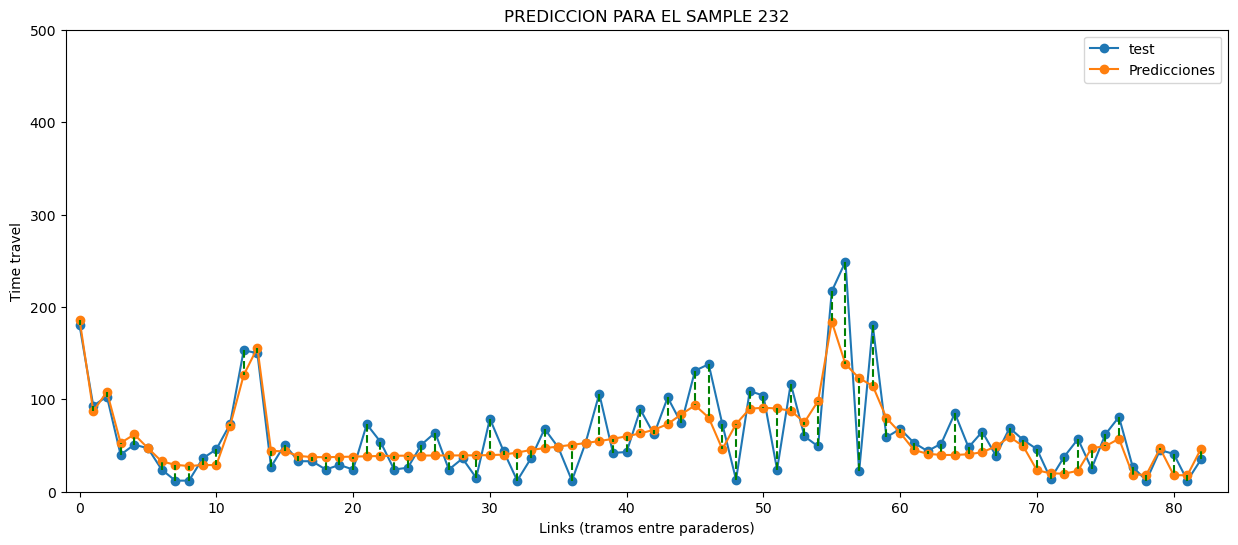

In [45]:
m = 83
n = 166

plt.figure(figsize=(15, 6))
plt.plot(np.arange(0, 83), y_ts[m:n].reshape(-1, 1), label='test',marker='o')
plt.plot(np.arange(0, 83), y_ts_pred[m:n].reshape(-1, 1), label='Predicciones',marker='o')
links_83 = np.arange(0, 83)
for i in range(len(links_83)):
    plt.plot([links_83[i], links_83[i]], [ y_ts[m:n].reshape(-1, 1)[i], y_ts_pred[m:n].reshape(-1, 1)[i]], 'g--')

# Ajustar los límites de los ejes
plt.xlim(-1, 84)  # Ajustar límites del eje x
plt.ylim(0, 500)  # Ajustar límites del eje y
#plt.xticks(np.arange(83))
plt.xlabel('Links (tramos entre paraderos)')
plt.ylabel('Time travel')
plt.legend()
plt.title("PREDICCION PARA EL SAMPLE 232")
# Mostrar el gráfico
plt.show()

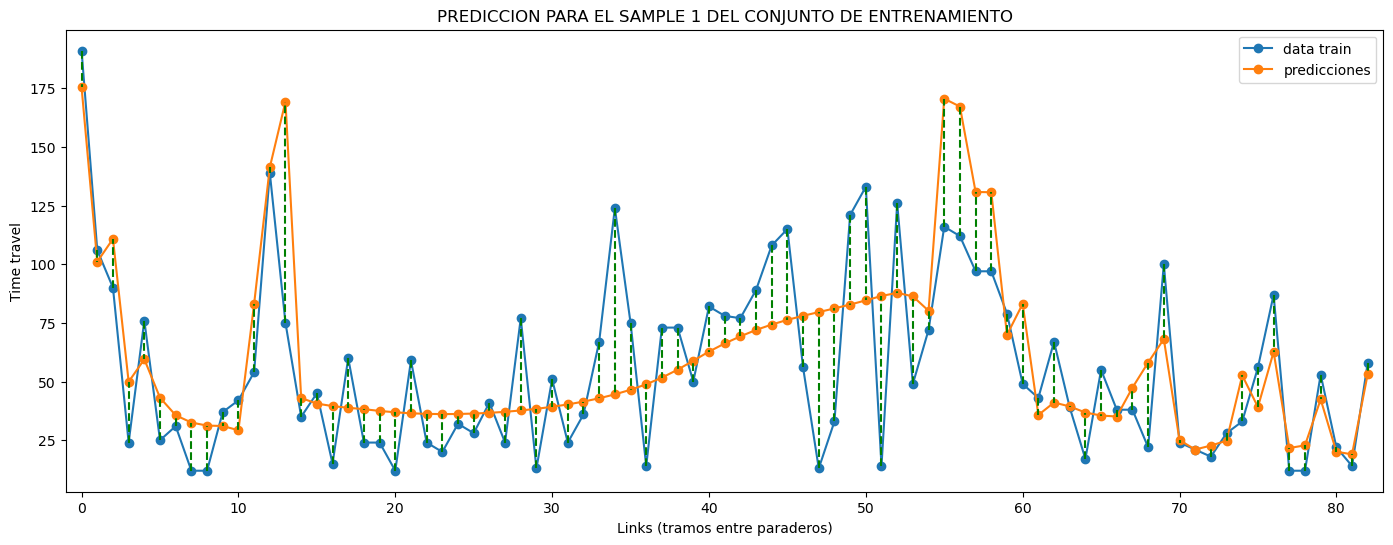

In [271]:
plot_predict_samples(1,df,y_train_predictions)

In [ ]:
plot_predict_samples_test(2,x_ts_s,y_ts_pred)

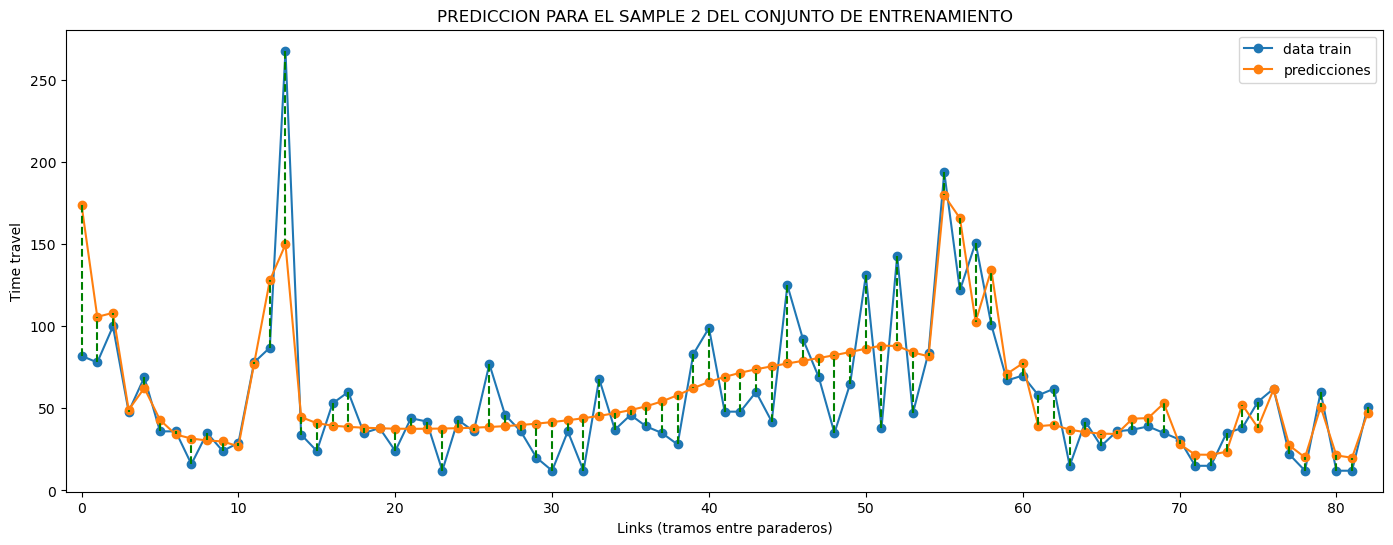

In [199]:
plot_predict_samples(2,df,y_train_predictions)

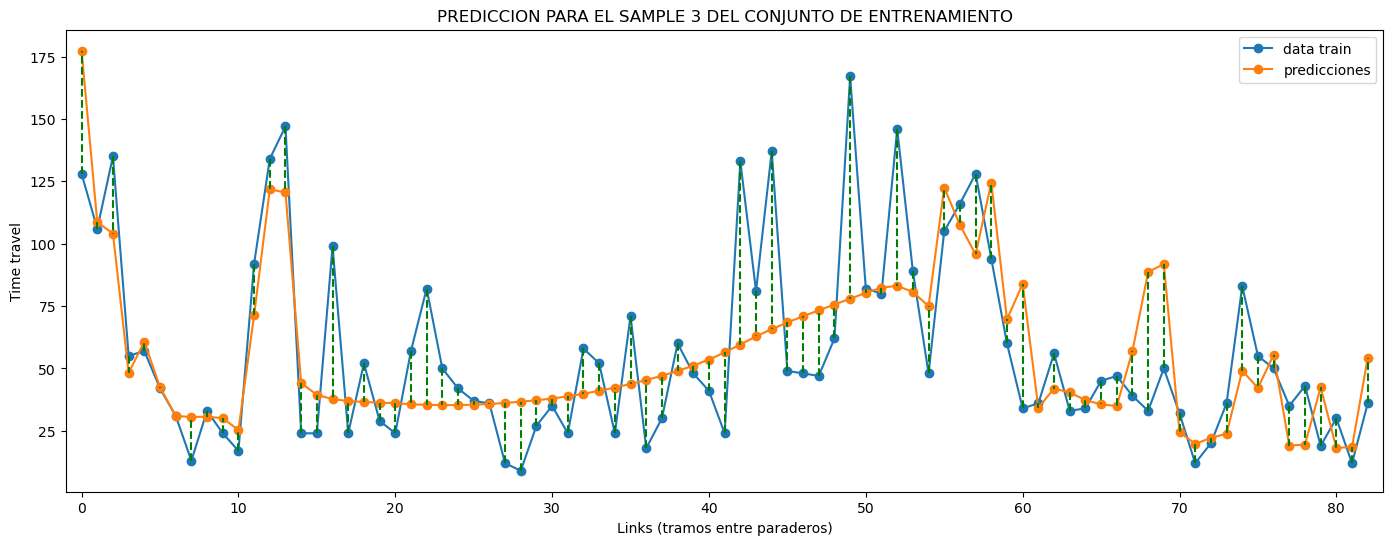

In [200]:
plot_predict_samples(3,df,y_train_predictions)

# Prediccion de paraderos uni-step

In [182]:
def prediccion_links(ts, ts_secuences, paraderoA, paraderoB, stops, Hora, Minuto):
    # Tiempos
    times_sum = []

    #Buscar Hora
    find_=ts.reset_index()
    samples_finded = find_[(find_['horas']==Hora) & (find_['links']==0) & (find_['minute']==Minuto)].index
    if samples_finded.shape[0] == 0:
        index_last_secuence = 3735
    else:
        index_last_secuence = samples_finded[0]

    last_secuence = ts_secuences[index_last_secuence].reshape(1,83, 4, 1,1)
    print(" === PREDICCION === ")
    print("id test sample: ",  index_last_secuence)
    print("Hora referencia: ",  last_secuence[0][0][1][0][0],":", last_secuence[0][0][2][0][0])
    for i in range(paraderoB):
        #print(i)
        #Dimension para predecir (1,[0-83],2)
        prueba_prediccion = modelo.predict(last_secuence,verbose=0)
        # INICIO LINEA DE PRUEBA
        # PARA LSTM #prueba_prediccion = prueba_prediccion.reshape(prueba_prediccion.shape[0],1)
        prueba_prediccion = prueba_prediccion[:, 0, 0, 0].reshape((-1, 1))
        # FIN LINEA DE PRUEBA
        prueba_prediccion_escalado = scaler.inverse_transform(prueba_prediccion)

        #Ultimo elemento a agregar
        last_element = np.array([[last_secuence[0][0][0],last_secuence[0][0][1] ,last_secuence[0][0][2], prueba_prediccion]], dtype=object)
        #print(last_element)
        #print(scaler.inverse_transform(last_secuence[0][0][1].reshape(-1,1)))
        #print(np.append(last_secuence, np.broadcast_to(last_element, (1, 83, 4, 1, 1)), axis=0))
        #print('PASÓ')
        #Agregar el ultimo elemento de prediccion no escalado y eliminar el primero
        last_secuence = np.append(last_secuence,  np.broadcast_to(last_element, (1, 83, 4, 1, 1)),axis=0).astype(np.float64)#.reshape(1,83, 4,1,1).astype(np.float64)
        last_secuence = last_secuence[1:, :, :, :, :]


        times_sum.append(prueba_prediccion_escalado[0][0])
        #print(i, last_secuence.shape, last_secuence.dtype)

    print("Predicción de tiempo de llegada para el paradero '",stops[paraderoA],"' al paradero '", stops[paraderoB], "' es: ", sum(times_sum[paraderoA:paraderoB+1])," segundos.")
    return sum(times_sum[paraderoA:paraderoB+1])


## Realizar predicciones

In [61]:
paraderos = pd.read_csv('../data/busstops_ida.csv', usecols=['number','name'])
stops = dict(zip(paraderos['number'], paraderos['name']))
#stops

In [62]:
df_resultado = pd.concat([paraderos[i:i+25].reset_index(drop=True) for i in range(0, len(paraderos), 25)], axis=1)
print(df_resultado.to_string(index=False))

 number                name  number                      name  number                     name  number          name
      0              inicio      25                 Cachimayo      50         Colegio Clorinda    75.0 Grifo entrada
      1         primer stop      26                     Enaco      51         Mercado Wuanchaq    76.0       Esquina
      2        segundo stop      27                Sol de oro      52                   Paccha    77.0        Subida
      3            Ccollana      28                San Miguel      53                 Estación    78.0       Primero
      4     Puente Huaccoto      29                Mercadillo      54                   Gradas    79.0       Segundo
      5               Kayra      30                Santa Rosa      55              Puente Grau    80.0    Reservorio
      6            Forestal      31                 Camionero      56                    Belén    81.0        Cuarto
      7         Grifo Tapia      32                   Séptimo   

In [ ]:
a=ts.reset_index()
valor = a[(a['horas']==16) & (a['links']==0) & (a['minute']==30)].index
valor.shape

In [ ]:
a=tr.reset_index()
b=vl.reset_index()
c=ts.reset_index()
print(sorted(a['horas'].unique()))
print(sorted(b['horas'].unique()))
print(sorted(c['horas'].unique()))

In [ ]:
ts[].reset_index().head(83*20+83)

In [ ]:
x_ts_s[8798]

In [ ]:
x_ts_s[:, :, 0]

In [ ]:
print(x_ts_s[0].reshape(1,83, 4)[0][0][2]) # 1 Es la hora, 2 es el minuto

tramo = 0.
hora = 7.
minuto = 30.

indices = np.argwhere((x_ts_s[:, :, 0] == tramo) & (x_ts_s[:, :, 1] == hora) & (x_ts_s[:, :, 2] == minuto))
print(indices)

In [190]:
#first_sample_test = x_ts_s[1660].reshape(1,83, 4)  #1660 sample de las 10:30 am
first_sample_test = x_ts_s[3735].reshape(1,83, 4,1,1)  #3735 sample de las 16:45 pm
#first_sample_test = x_tr_s[0].reshape(1,83, 4)  #0 sample train de las 7:30 am
#last_sample_test = x_vl_s[-1].reshape(1,83, 2)
#±

predict_paraderos = prediccion_links(ts ,x_ts_s, paraderoA = 39, paraderoB = 46, stops = stops, Hora = 10, Minuto = 30)

print(f"{predict_paraderos:.2f} segundos equivale a {(predict_paraderos//60):.0f} minutos y {(predict_paraderos%60):.2f} segundos con un margen de error de [{intervalo_simetrico[0]:.3f}, +{intervalo_simetrico[1]:.3f}] segundos")

 === PREDICCION === 
id test sample:  1660
Hora referencia:  10.0 : 30.0
Predicción de tiempo de llegada para el paradero ' Primero ' al paradero ' Puerta Universidad UNSAAC ' es:  1159.3633575439453  segundos.
1159.36 segundos equivale a 19 minutos y 19.36 segundos con un margen de error de [-47.717, +65.091] segundos


# FIN PRUEBAS